In [37]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [38]:
# Load the data
data = pd.read_csv('Resources/AAPL.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter the data to include only the last 10 years
# cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=4)
# data = data[data['Date'] >= cutoff_date]

# Ensure the data is sorted by date
data = data.sort_values(by='Date')

In [39]:
# Creating moving average features
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# Drop the rows with NaN values (caused by rolling windows)
data = data.dropna()

# Define the target variable and features
features = ['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_10']
target = 'Close'

# Split the data into training and testing sets
train_data = data[data['Date'] < '2022-01-01']  
test_data = data[data['Date'] >= '2022-01-01']  

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [40]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
r2_score = r2_score(y_test, predictions)
print(f'R squared: {r2_score}')

Mean Squared Error: 33.526875906962196
R squared: 0.8911323042619144


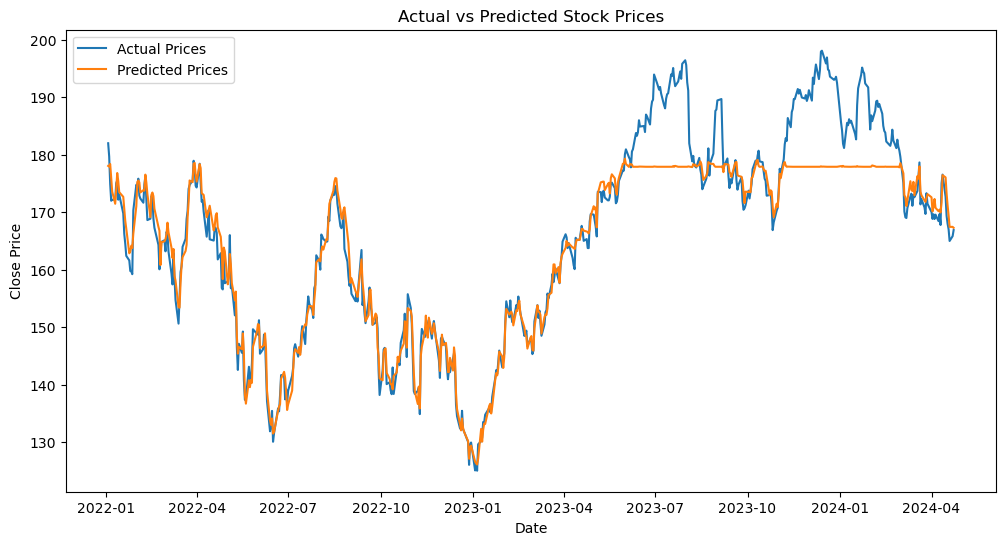

In [41]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], y_test, label='Actual Prices')
plt.plot(test_data['Date'], predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [42]:
# Predict future prices for the next month
def predict_next_month(model, last_data, features, days=30):
    future_predictions = []
    last_date = last_data['Date'].max()
    
    for i in range(days):
        last_row = last_data.iloc[-1]
        new_row = last_row.copy()
        
        # Move the date forward by one day
        new_row['Date'] = last_date + pd.Timedelta(days=1)
        
        # Predict the next closing price
        prediction = model.predict([last_row[features]])[0]
        new_row['Close'] = prediction
        
        # Update the moving averages
        last_data = pd.concat([last_data, new_row.to_frame().T], ignore_index=True)
        last_data['MA_5'] = last_data['Close'].rolling(window=5).mean()
        last_data['MA_10'] = last_data['Close'].rolling(window=10).mean()
        
        # Append the prediction to the future predictions list
        future_predictions.append(new_row)
        
        # Update the last_date
        last_date = new_row['Date']
        
        # Remove NaN values that may appear during the moving average calculation
        last_data = last_data.dropna()
    
    return pd.DataFrame(future_predictions)

# Prepare the last data point for prediction
last_data = data.copy()

# Predict future prices
future_predictions = predict_next_month(model, last_data, features)

c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\caila\Desktop\envs\de

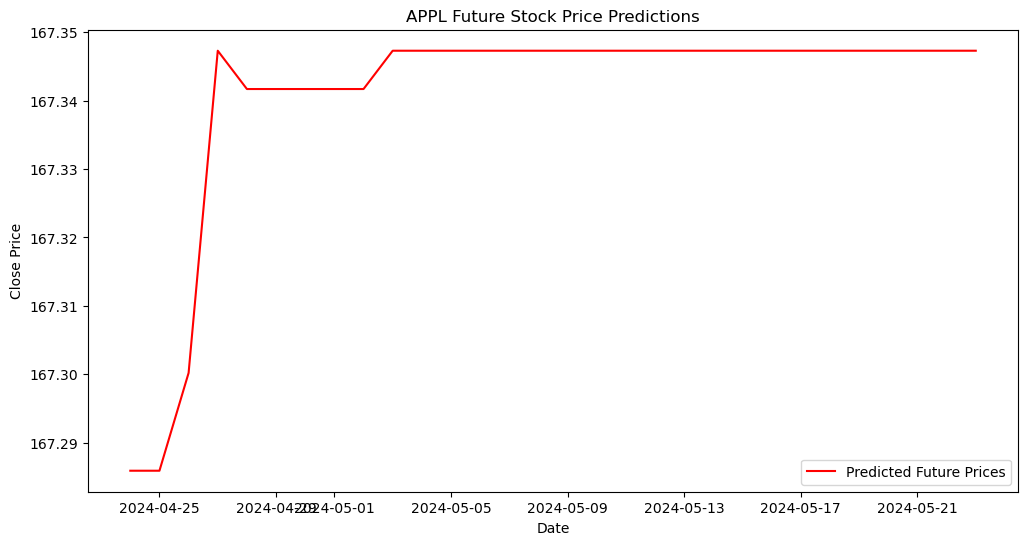

In [43]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_predictions['Date'], future_predictions['Close'], label='Predicted Future Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('APPL Future Stock Price Predictions')
plt.legend()

# Save the figure
plt.savefig('One-Month-Prediction-Graphs/APPLmonthbydayforecast.png')

plt.show()

In [45]:
print(future_predictions[['Date', 'Close']])

            Date       Close
10930 2024-04-24  167.285902
10922 2024-04-25  167.285902
10914 2024-04-26  167.300202
10906 2024-04-27  167.347302
10898 2024-04-28  167.341702
10890 2024-04-29  167.341702
10882 2024-04-30  167.341702
10874 2024-05-01  167.341702
10866 2024-05-02  167.341702
10858 2024-05-03  167.347302
10850 2024-05-04  167.347302
10842 2024-05-05  167.347302
10834 2024-05-06  167.347302
10826 2024-05-07  167.347302
10818 2024-05-08  167.347302
10810 2024-05-09  167.347302
10802 2024-05-10  167.347302
10794 2024-05-11  167.347302
10786 2024-05-12  167.347302
10778 2024-05-13  167.347302
10770 2024-05-14  167.347302
10762 2024-05-15  167.347302
10754 2024-05-16  167.347302
10746 2024-05-17  167.347302
10738 2024-05-18  167.347302
10730 2024-05-19  167.347302
10722 2024-05-20  167.347302
10714 2024-05-21  167.347302
10706 2024-05-22  167.347302
10698 2024-05-23  167.347302


In [46]:
future_predictions.to_csv('One-Month-Predictions/AAPL-prediction.csv', index=False)

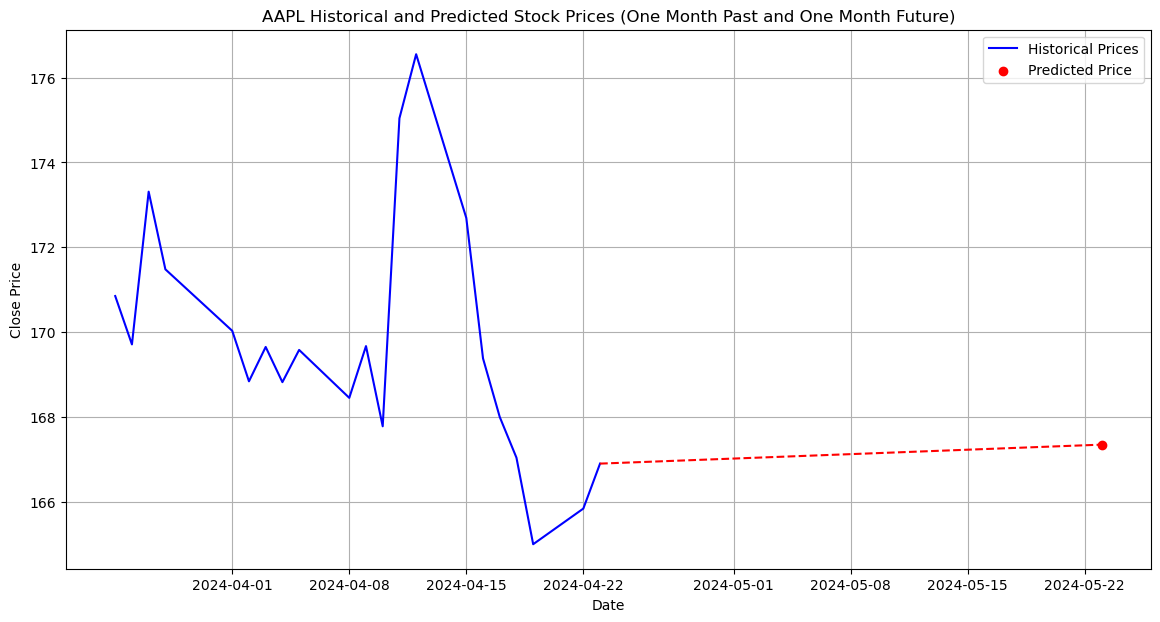

In [47]:
# Combine historical and predicted data
combined_data = pd.concat([data, future_predictions])

# Filter the combined data to include only the last month of historical data and next month of predictions
one_month_ago = data['Date'].max() - pd.DateOffset(days=30)
future_predictions_start = future_predictions['Date'].min()

filtered_combined_data = combined_data[
    (combined_data['Date'] >= one_month_ago) & 
    (combined_data['Date'] <= future_predictions_start + pd.DateOffset(days=30))
]

# Separate historical and predicted data
historical_data = filtered_combined_data[filtered_combined_data['Date'] <= data['Date'].max()]
predicted_data = filtered_combined_data[filtered_combined_data['Date'] > data['Date'].max()]

# Get the final data point from the predicted data
final_predicted_data = predicted_data.iloc[-1]

# Plot combined data for the last month and next month
plt.figure(figsize=(14, 7))
plt.plot(historical_data['Date'], historical_data['Close'], label='Historical Prices', color='blue')
plt.scatter(final_predicted_data['Date'], final_predicted_data['Close'], label='Predicted Price', color='red', marker='o')
plt.plot([historical_data['Date'].iloc[-1], final_predicted_data['Date']], [historical_data['Close'].iloc[-1], final_predicted_data['Close']], 'r--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Historical and Predicted Stock Prices (One Month Past and One Month Future)')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('One-Month-Comparison-Graphs/AAPLmonthforecastcomparison.png')

plt.show()